## Data Science Internship
#### Remoção de valores faltantes
##### Autor: Pedro Henrique Braga Lisboa

#### Sumário
----
* [Teste de métodos de preenchimento](#teste_preenchimento)
* [Resultado do preenchimento agrupado por horário](#resultado_horario)
* [Resultado do preenchimento direto para lacunas pequenas](#resultado_direto)
* [Escolha do método](#escolha_metodo)

In [135]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools

from functions import plot_daily_data, get_na_sequences
from functions import error_measure, single_impute_na, iter_impute_na

from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = [10.0, 10.0]
matplotlib.rc('font', family='Arial')
sns.set_style("whitegrid")

### Teste de métodos de preenchimento <a name="teste_preenchimento"></a>
---

#### De forma a tentar mensurar o desempenho de diferentes métodos de preenchento de lacunas, um trecho do conjunto de dados terá intervalos de valores removidos artificialmente e, em seguida, o erro de reconstrução de cada método será avaliado de forma a escolher a estratégia de preenchimento.

#### Métodos: 
   * preenchimento iterativo usando KNeighborsRegression
   * interpolação (linear, quadrática, cúbica)
   * preenchimento com a média/mediana

#### O trecho de teste foi extraido do conjunto de dados de forma que não houvesse nenhum valor faltante não houvesse lacunas de tempo.

#### O preenchimento de intervalos de valores faltantes muito grandes (de mais de algumas horas) por interpolação será realizado separando as variáveis por horário. Agrupando valores de um mesmo horário para dias consecutivos garante a redução do intervalo de valores consecutivos que devem ser interpolados e evita a interferência no padrão cíclico diário observado na análise exploratória para a variável de predição. 

In [145]:
dataset = pd.read_csv("qualidade_do_ar_padronizado.csv")
na_count = dataset.isna().sum()

columns_with_na = list(na_count[na_count !=0].index.values)
columns_with_na.remove("NMHC(GT)")

seqs = dataset.isna()[columns_with_na].apply(lambda x: not x.any(),axis=1)
seqs = [list(group[1]) for group in itertools.groupby(seqs, lambda x: True if x else False)]

def generate_na(dataset, possible_intervals, size = 10,verbose=True, show_intervals=False):
    col_selector = list(columns_with_na)
    col_selector.append("Hour")
    subset = dataset.iloc[-579:].loc[:, col_selector]
    target = dataset.iloc[-579:].loc[:, col_selector]
    indices = np.random.randint(low=0,high=578-(size+max(possible_intervals)), size=size)
    indices = np.concatenate([list(range(index, index+possible_intervals[np.random.randint(0,len(possible_intervals))])) 
                              for index in indices])
    hour = subset["Hour"]
    subset.drop("Hour",axis=1,inplace=True)
    subset.iloc[indices] = np.nan
    subset["Hour"] = hour
    if verbose:
        print("Quantidade de valores faltantes gerados artificialmente para cada variável\n")
        print(subset.isna().sum())

    if show_intervals:
        print("\n\nTamanho de cada intervalo gerado\n")
        for column in subset.drop("Hour",axis=1):
            print(column + ': ' + str(get_na_sequences(subset, column)))
    return subset, target, indices

subset, target, indices = generate_na(dataset, [20, 50, 70], show_intervals=True)

Quantidade de valores faltantes gerados artificialmente para cada variável

PT08.S1(CO)      328
C6H6(GT)         328
PT08.S2(NMHC)    328
NOx(GT)          328
PT08.S3(NOx)     328
NO2(GT)          328
PT08.S4(NO2)     328
PT08.S5(O3)      328
T                328
RH               328
AH               328
Hour               0
dtype: int64


Tamanho de cada intervalo gerado

PT08.S1(CO): [126, 112, 70, 20]
C6H6(GT): [126, 112, 70, 20]
PT08.S2(NMHC): [126, 112, 70, 20]
NOx(GT): [126, 112, 70, 20]
PT08.S3(NOx): [126, 112, 70, 20]
NO2(GT): [126, 112, 70, 20]
PT08.S4(NO2): [126, 112, 70, 20]
PT08.S5(O3): [126, 112, 70, 20]
T: [126, 112, 70, 20]
RH: [126, 112, 70, 20]
AH: [126, 112, 70, 20]


### Resultado do preenchimento agrupado por horário  <a name="resultado_horario"></a>
---

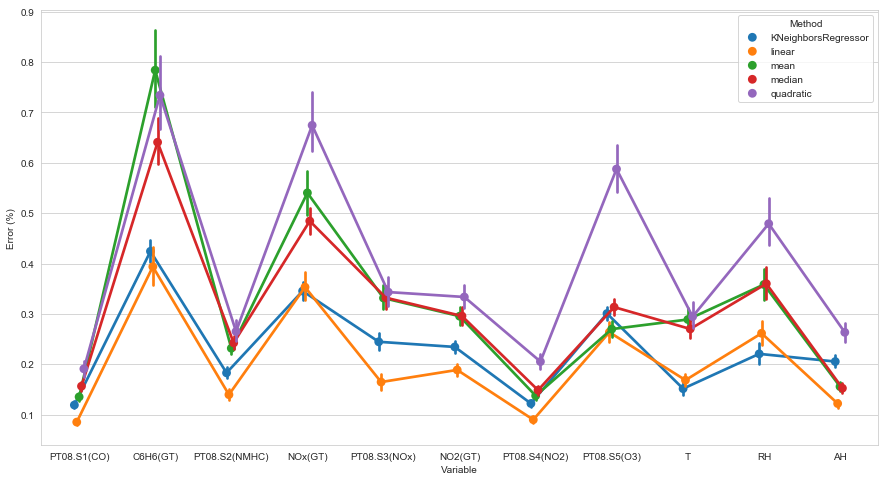

In [147]:
knn_err = iter_impute_na(subset, target, KNeighborsRegressor(n_neighbors=3), indices, max_iter=150)
ln_err = single_impute_na(subset, target, "linear", indices)
mean_err = single_impute_na(subset, target, "mean", indices)
median_err = single_impute_na(subset, target, "median", indices)
quad_err = single_impute_na(subset, target, "quadratic", indices)

errors_df = pd.concat([knn_err, ln_err, mean_err, median_err, quad_err], axis=0)
molten_err = errors_df.melt(id_vars="Method", var_name="Variable", value_name="Error (%)")

fig, ax = plt.subplots(nrows=1, figsize=(15,8))
sns.pointplot(x="Variable", y="Error (%)", hue="Method",data=molten_err, dodge=True)
# errors_df = pd.concat([br_err, knn_err])




#### Para o preenchimento por horário, o método de interpolação linear apresentou um resultado comparável ao método iterativo com KNNRegression e obteve erros menores para a maioria das variáveis. 

### Resultado do preenchimento direto para lacunas pequenas <a name="resultado_direto"></a>
---

#### Foram geradas lacunas de tamanhos 1, 2 e 3

In [148]:
subset, target, indices = generate_na(dataset, [1,2,3], size=50,show_intervals=False)

Quantidade de valores faltantes gerados artificialmente para cada variável

PT08.S1(CO)      97
C6H6(GT)         97
PT08.S2(NMHC)    97
NOx(GT)          97
PT08.S3(NOx)     97
NO2(GT)          97
PT08.S4(NO2)     97
PT08.S5(O3)      97
T                97
RH               97
AH               97
Hour              0
dtype: int64


/home/pedrolisboa/.virtualenvs/.virtualenvs/radix/lib/python3.5/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


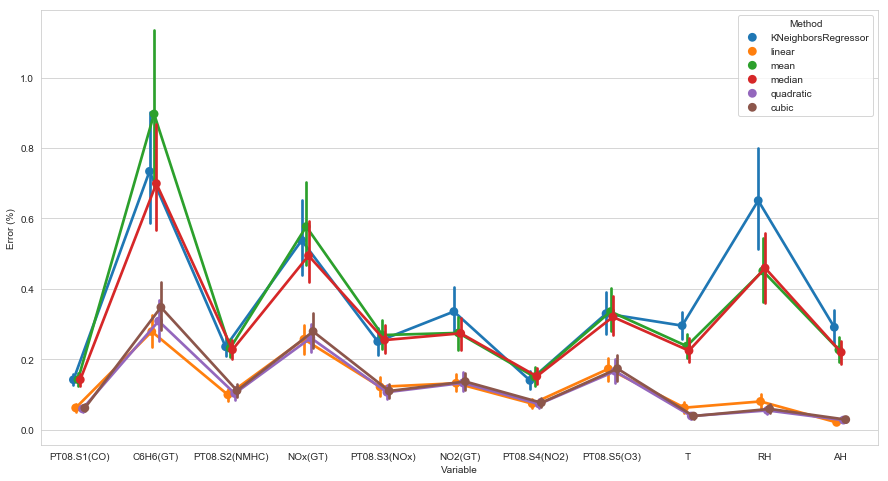

In [81]:
knn_err = iter_impute_na(subset, target, KNeighborsRegressor(n_neighbors=3), indices, False, max_iter=150)
ln_err = single_impute_na(subset, target, "linear", indices, False)
mean_err = single_impute_na(subset, target, "mean", indices, False)
median_err = single_impute_na(subset, target, "median", indices, False)
quad_err = single_impute_na(subset, target, "quadratic", indices, False)
cub_err = single_impute_na(subset, target, "cubic", indices, False)

errors_df = pd.concat([knn_err, ln_err, mean_err, median_err, quad_err, cub_err], axis=0)
molten_err = errors_df.melt(id_vars="Method", var_name="Variable", value_name="Error (%)")

fig, ax = plt.subplots(nrows=1, figsize=(15,8))
sns.pointplot(x="Variable", y="Error (%)", hue="Method",data=molten_err, dodge=True)

#### Novamente, o método de interpolação linear apresentou o melhor resultado, junto com a interpolação quadrática.

### Escolha do método <a name="escolha_metodo"></a>
---

#### Como o modelo de interpolação linear apresentou os melhores resultados nos dois casos, será aplicado ao resto do conjunto de dados para o preenchimento dos valores faltantes. Lacunas de comprimento máximo de 3 entradas serão diretamente interpoladas enquanto intervalos maiores serão preenchidos pelo agrupamento por horário.

#### A variável NMHC(GT) será deixada de fora do modelo de regressão. Além de possuir uma taxa de 90% de lacunas, os valores dessa variável estão concentrados apenas nos primeiros meses da coleta, impossibilidando o preenchimento adequado para o resto do ano com os métodos apresentados nessa análise. 

#### Como visto na análise exploratória, os dados são não estacionários (cicloestacionários), variando a distribuição de valores de acordo com a estação do ano, o que também dificultaria a utilização (e validação) de outros métodos, uma vez que têm-se disponível apenas a distribuição do primeiro e (parcialmente) do segundo trimestre. 

In [162]:
dataset.drop("NMHC(GT)", axis=1, inplace=True)
partialy_imputed_dataset = dataset
partialy_imputed_dataset[columns_with_na] = dataset[columns_with_na].interpolate(method='linear', limit=3)
imputed_dataset = partialy_imputed_dataset.groupby("Hour").apply(lambda group: group.interpolate(method='linear'))

## Função para gerar as imagens na pasta Pictures
# plot_daily_data(dataset, columns_with_na, "with_missing_data")
# plot_daily_data(imputed_dataset, columns_with_na, "imputed_data")

imputed_dataset.to_csv("qualidade_do_ar_preenchida.csv", index=False)

#### De forma a preservar a estrutrua dos dados sem a alteração indesejada de pontos válidos do sinal, não será utilizado nenhuma técnica para estatística para a remoção de outliers. No entanto, a avaliação do modelo de regressão será feito com o Erro Médio Quadrático, de forma a levar em consideração (penalizar) erros de predição elevados (em decorrência da tentativa de predição de um outlier).  
